In [1]:
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import scipy.stats as stats
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import binom
from scipy.stats import pearsonr
import koreanize_matplotlib

In [2]:
#1. **데이터 병합** - 06_Data 폴더 내의 모든 데이터를 병합하여 변수 **df3**에 저장한 후, df3를 활용하여 아래 문제들을 해결하시오.
total = []

for i in range(5, 9):
    df = pd.read_csv(f'06_Data/기간발주데이터_190{i}001.csv')
    total.append(df)

df3 = pd.concat(total, ignore_index=True)

In [3]:
# 2. **쿠팡출고수량 증감률 계산 (전체)** - 2019년 5월과 8월의 **쿠팡출고수량**을 비교하여, 8월의 수량이 5월 대비 몇 퍼센트 증가하였는지 계산하시오.

df3['날짜'] = pd.to_datetime(df3['날짜'])
may = df3.groupby(df3['날짜'].dt.month)['쿠팡출고수량'].sum()[5]
august = df3.groupby(df3['날짜'].dt.month)['쿠팡출고수량'].sum()[8]
# print(df3.groupby(df3['날짜'].dt.month)['쿠팡출고수량'].sum())
pct = (august - may)/may * 100

df_result = pd.DataFrame({
    '5월': [may],
    '8월': [august],
    '증감률 (%)': [pct]
})

df_result

,5월,8월,증감률 (%)
0,301973,141153,-53.256417


In [4]:
# 3. **쿠팡출고수량 증감률 계산 (카테고리별)** - 각 카테고리별로 5월과 8월의 **쿠팡출고수량** 증감률(퍼센트 변화)을 산출하시오.

df_grouped = df3.groupby(["카테고리", df3["날짜"].dt.month])["쿠팡출고수량"].sum().unstack()
may = df_grouped[5]
august = df_grouped[8]
pct = (august - may)/may * 100

df_result = pd.concat([may, august, pct], axis=1)
df_result.columns = ['5월', '8월', '증감률 (%)']
df_result

,5월,8월,증감률 (%)
카테고리,,,
F&B,23687,9905,-58.183814
ST,2442,1615,-33.865684
기타,1647,874,-46.933819
덴탈케어,74280,30661,-58.722402
매입브랜드,1769,635,-64.104014
세탁세제,90089,44910,-50.149297
주방세제,46048,24490,-46.816366
헤어케어,62011,28063,-54.745126


In [9]:
# 4. **발주중단 데이터 분석** - **발주가능상태** 컬럼에서 값이 '발주중단'인 데이터만 추출한 후, 
# - 각 카테고리의 빈도수를 확인하고, - 연속형 변수(예: 수량)의 기술 통계량(평균, 표준편차, 최소값, 최대값 등)을 계산하시오.

df4 = df3[df3['발주가능상태'] == '발주중단']
category_counts = df4['카테고리'].value_counts().reset_index()
print(category_counts)
df4.describe()

   카테고리  count
0  헤어케어     78
1  세탁세제     14
2  덴탈케어      3


,Unnamed: 0,날짜,SKU ID,입고수량,쿠팡출고수량,쿠팡현재재고수량,자재번호,입수,출고수량,재고수량
count,95.000000,95,9.500000e+01,95.000000,95.000000,95.000000,9.500000e+01,95.000000,95.000000,95.000000
mean,28616.242105,2019-07-15 00:00:00,3.559700e+06,14.357895,10.989474,516.526316,6.038457e+06,7.515789,2.095614,318.160424
min,15576.000000,2019-06-18 00:00:00,3.097770e+05,0.000000,0.000000,0.000000,5.008395e+06,4.000000,0.000000,0.000000
25%,26683.000000,2019-07-09 12:00:00,2.383418e+06,0.000000,2.000000,20.500000,6.068195e+06,4.000000,0.200000,43.036364
50%,29684.000000,2019-07-15 00:00:00,3.367647e+06,0.000000,8.000000,164.000000,6.075507e+06,10.000000,0.800000,210.000000
75%,31374.500000,2019-07-21 00:00:00,3.367649e+06,0.000000,14.500000,246.000000,6.075508e+06,10.000000,3.375000,379.307692
max,36563.000000,2019-08-07 00:00:00,1.023964e+07,216.000000,100.000000,3077.000000,6.075508e+06,10.000000,16.666667,2080.000000
std,4672.622153,NaN,2.659679e+06,40.203714,14.443945,938.434514,1.870319e+05,2.763220,2.906945,399.025974


In [11]:
# 5. **특정 주의 최고 쿠팡출고수량 카테고리 확인** - 2019년 7월 두 번째 주에 **쿠팡출고수량**이 가장 높은 카테고리를 확인하시오.
from datetime import datetime

target_week = datetime(2019, 7, 8).isocalendar().week

df5 = df3[df3['날짜'].dt.isocalendar().week == target_week]
df5.groupby('카테고리')['쿠팡출고수량'].sum().idxmax()

'세탁세제'

In [23]:
# 6. **자재별 평균 및 등급 분류와 카테고리 확인**
#    - 각 **자재명**별로 **쿠팡출고수량**과 **입고수량**의 평균을 계산한 후,
#    - 계산된 결과에서 **쿠팡출고수량** 평균을 기준으로
#        - 상위 10%에 해당하는 자재명을 'A',
#        - 상위 30%를 'B',
#        - 상위 60%를 'C',
#        - 나머지를 'D'로 분류하는 **등급분류** 파생 변수를 생성하고,
#    - 각 등급별로 가장 빈번하게 등장하는 카테고리 항목을 확인하시오.

df3.head()

df6 = df3.groupby('자재명')[['쿠팡출고수량', '입고수량']].mean().reset_index()
df6.columns = ['자재명', '쿠팡출고수량_평균', '입고수량']

quantiles = df6['쿠팡출고수량_평균'].quantile([0.9, 0.7, 0.4]).values

def assign_grade(value):
    if value >= quantiles[0]:
        return 'A'
    elif value >= quantiles[1]:
        return 'B'
    elif value >= quantiles[2]:
        return 'C'
    else:
        return 'D'

# 파생변수 생성
df6['등급분류'] = df6['쿠팡출고수량_평균'].apply(assign_grade)
df3_merged = df3.merge(df6[['자재명', '등급분류']], on='자재명', how='left')

df3_merged.groupby('등급분류')['카테고리'].agg(lambda x: x.value_counts().idxmax())

등급분류
A    주방세제
B    세탁세제
C    세탁세제
D      ST
Name: 카테고리, dtype: object

카테고리를 입력하세요 :  헤어케어


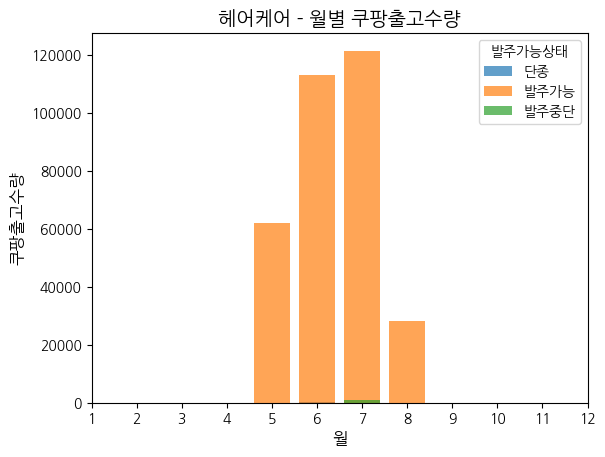

In [43]:
# 7. **사용자 입력 기반 월별 시각화 함수 작성**
#    - 사용자로부터 특정 **카테고리**를 입력받은 후, 해당 카테고리의 데이터에서
#        - **발주가능상태**별 및 날짜 컬럼을 활용해 계산한 **월**별 **쿠팡출고수량** 합계를 산출하고 시각화하며,
#        - 결과 그래프를 `카테고리명_월별_쿠팡출고량.png` 파일로 저장하는 함수를 작성하시오.

category = input('카테고리를 입력하세요 : ')

df7 = df3[df3['카테고리'] == category]
df7_grouped = df7.groupby(['발주가능상태', df7['날짜'].dt.month])['쿠팡출고수량'].sum().unstack()

for state in df7_grouped.index:
    plt.bar(df7_grouped.columns, df7_grouped.loc[state], label=state, alpha=0.7)

plt.title(f"{category} - 월별 쿠팡출고수량", fontsize=14)
plt.xlabel("월", fontsize=12)
plt.ylabel("쿠팡출고수량", fontsize=12)
plt.xticks(range(1, 13))  # x축을 1~12월로 설정
plt.legend(title="발주가능상태")

filename = f"{category}_월별_쿠팡출고량_상태별.png"
plt.savefig(filename, dpi=300)
plt.show()

In [45]:
# 8. **최다 빈도 카테고리 데이터 추출 및 저장**
#    - 데이터에서 가장 많이 등장하는 카테고리에 해당하는 데이터 중,
#        - **입고수량**이 높은 상위 100개의 데이터를 추출하여
#        - `result_category.xlsx` 파일로 저장하시오.

max_category = df3.groupby('카테고리').size().idxmax()
df8 = df3[df3['카테고리'] == max_category].sort_values('입고수량', ascending=False).head(100)
df8.to_excel('result_category.xlsx', index = False)

In [47]:
# 9. **7월과 8월의 평균 및 합계 차이 계산**
#    - 각 카테고리별로 7월과 8월의 **쿠팡출고수량**에 대한 평균 및 합계를 산출한 후,
#        - 두 달 간의 차이를 계산하시오.

july = df3[df3['날짜'].dt.month == 7].groupby('카테고리')['쿠팡출고수량'].agg(['mean', 'sum'])
august = df3[df3['날짜'].dt.month == 8].groupby('카테고리')['쿠팡출고수량'].agg(['mean', 'sum'])
diff = august - july

result = pd.concat([july, august, diff], axis = 1)
result.columns = ['7월_평균', '7월_합계', '8월_평균', '8월_합계', '평균_차이', '합계_차이']
result

,7월_평균,7월_합계,8월_평균,8월_합계,평균_차이,합계_차이
카테고리,,,,,,
F&B,47.198448,42573,59.668675,9905,12.470227,-32668
ST,6.241996,8383,10.157233,1615,3.915237,-6768
기타,22.482517,3215,25.705882,874,3.223365,-2341
덴탈케어,59.998344,144956,81.113757,30661,21.115412,-114295
매입브랜드,14.116162,2795,16.710526,635,2.594365,-2160
세탁세제,48.936193,184832,59.483444,44910,10.547251,-139922
주방세제,76.182138,108331,93.473282,24490,17.291145,-83841
헤어케어,52.085215,122244,67.785024,28063,15.699809,-94181


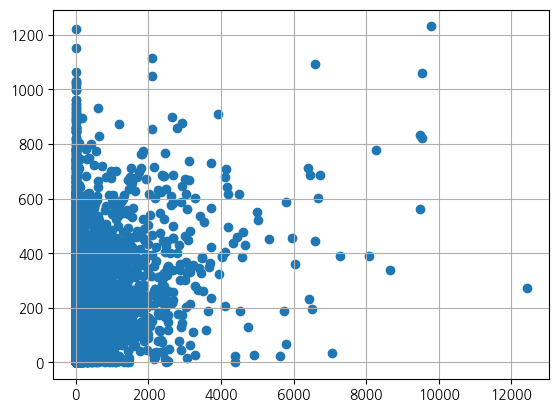

In [49]:
# 10. **상관관계 시각화**
#     - **입고수량**과 **쿠팡출고수량** 간의 상관관계를 산점도를 이용하여 시각화하시오.
X = np.array(df3['입고수량'])
Y = np.array(df3['쿠팡출고수량'])

pearsonr(X, Y)

plt.scatter(X, Y)
plt.grid()
plt.show()

In [25]:

# 자재별 평균 계산
material_avg = df.groupby('자재명').agg({'쿠팡출고수량': 'mean', '입고수량': 'mean'}).reset_index()
material_avg

,자재명,쿠팡출고수량,입고수량
0,10순샘BubbleOlive 350ml용기,57.000000,64.285714
1,14New바세린리프팅 450ml로션,27.625000,0.000000
2,162080 스마트케어웨이브 4입,26.727273,97.090909
3,162080 스마트케어칫솔_4입,12.428571,62.857143
4,162080치석 집중케어 미세모 5+5,2.666667,0.000000
...,...,...,...
292,19트리오발효초 1.4L쿠팡,2.307692,4.230769
293,19트리오베이킹소다 1.2L쿠팡,188.285714,312.428571
294,19하나로플러스샴푸 680ml비듬두피케어책,15.750000,10.000000
295,19하나로플러스샴푸 680ml손상모발케어책,7.000000,19.555556


In [ ]:
# 평균 쿠팡출고수량 기준 내림차순 정렬
material_avg = material_avg.sort_values('쿠팡출고수량', ascending=False).reset_index(drop=True)
n = len(material_avg)

# 등급 부여 (인덱스 기준 비율 적용)
material_avg['등급'] = 'D'  # 기본 등급 D
material_avg.loc[:int(n*0.1)-1, '등급'] = 'A'
material_avg.loc[int(n*0.1):int(n*0.3)-1, '등급'] = 'B'
material_avg.loc[int(n*0.3):int(n*0.6)-1, '등급'] = 'C'

print("자재별 평균과 등급 분류 (상위 일부만 확인):")
material_avg